# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski [2.5 pkt]
4. Jakość kodu [0.5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [ ]:
from abc import abstractmethod, ABC
from typing import List
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from typing import Callable, Optional
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
#1. Mean squared error
def mse_loss(predicted: np.ndarray, actual: np.ndarray)->float:
    """
    MSE = 1/n * Σ (i=0 -> n) { ( y_pred_i - y_act_i ) ^ 2 }

    MSE    -> loss function
    n      -> number of samples (int n)
    y_pred -> predicted values (arr: [n])
    y_act  -> actual values (arr: [n])

    MSE output is one number (float)
    """
    loss = float((1 / int(predicted.size)) * np.sum( (predicted - actual) ** 2))
    assert type(loss) == float
    return loss

def mse_loss_derivative(predicted: np.ndarray, actual: np.ndarray)->np.ndarray:
    """
    MSE derivative = ∂MSE / ∂y_pred
    MSE' = 2/n * (y_pred - y_act)

    MSE' -> derivative of loss function
    n      -> number of samples (int n)
    y_pred -> predicted values (arr: [n])
    y_act  -> actual values (arr: [n])

    MSE' output: arr: [n] -> derivative of loss for each input node
    """
    assert predicted.ndim == 1
    shape_p = predicted.shape
    shape_a = actual.shape
    assert shape_p == shape_a

    loss_der = (2 / int(predicted.size)) * (predicted - actual)
    assert loss_der.shape == shape_a
    assert loss_der.ndim == 1

    return loss_der

In [ ]:
#2. Loss function change.
def categorical_cross_entropy(predicted, actual):
    """Categorical cross-entropy loss function"""
    loss = -np.sum(actual * np.log(predicted))
    return loss / float(predicted.shape[0])

def categorical_cross_entropy_derivative(predicted, actual):
    """Derivative of categorical cross-entropy loss function"""
    return predicted - actual

In [ ]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative)->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

In [ ]:
class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size: int = input_size
        self.output_size: int = output_size

        # OLD VERSION Initialize weights with small random values, and biases to zero
        # self.weights: np.ndarray = np.random.randn(input_size, output_size) * 0.01

        # NEW Xavier initialization:
        #  - Selected random values from a uniform distribution that ranges between -1 and 1
        #  - Then scaled weights down by factor 1 / sqrt( input_size )
        self.weights: np.ndarray = np.random.uniform(-1, 1, size=(input_size, output_size))
        self.weights /= np.sqrt(input_size)
        # Biases are initialized as zeros
        self.biases: np.ndarray = np.zeros(output_size)

    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward pass: Linear transformation + activation"""
        self.input: np.ndarray = x # save input for use in backwards pass

        # Σ (i=0 -> n) { x_i * θ_i + θ_n+1 } + bias
        self.output: np.ndarray = np.dot(x, self.weights) + self.biases

        return self.output

    def backward(self, output_error_derivative: np.ndarray)->np.ndarray:
        """Backward pass: Compute gradients with respect to input, weights and biases"""
        # Gradient with respect to weights
        assert self.input.ndim == 1
        assert output_error_derivative.ndim == 1
        assert output_error_derivative.size == self.output_size
        self.dWeights = np.outer(self.input, output_error_derivative)
        assert self.dWeights.shape == self.weights.shape
        # Gradient with respect to biases
        self.dBiases = output_error_derivative
        assert self.dBiases.shape == self.biases.shape

        # Compute the gradient with respect to input for the next layer
        input_error_derivative = np.dot(output_error_derivative, self.weights.T)
        return input_error_derivative

    def update_parameters(self)->None:
      """Update the weights and biases using gradient descent"""
      self.weights -= self.learning_rate * self.dWeights
      self.biases  -= self.learning_rate * self.dBiases

In [ ]:
class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        """Apply the tanh activation function"""
        self.input = x # Store the input for use in backward pass
        self.output = np.tanh(x)
        return self.output

    def backward(self, output_error_derivative)->np.ndarray:
        """
        Compute the gradient of the loss with respect to the input of this layer
        The derivative of tanh is ( 1 - tanh( x )^2 )
        """
        tanh_derivative = 1 - np.power( self.output, 2 )
        return output_error_derivative * tanh_derivative

In [ ]:
class ReLU(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = np.maximum(0, x)
        return self.output

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        relu_derivative = (self.input > 0).astype(float)  # Gradient 1 for x > 0, else -> 0
        return output_error_derivative * relu_derivative

In [ ]:
class LeakyReLU(Layer):
    def __init__(self, alpha: float = 0.01) -> None:
        super().__init__()
        self.alpha = alpha

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = np.where(x > 0, x, self.alpha * x)
        return self.output

    def backward(self, output_error_derivative: np.ndarray) -> np.ndarray:
        leaky_relu_derivative = np.where(self.input > 0, 1, self.alpha)  # # Gradient 1 for x > 0, else -> alpha
        return output_error_derivative * leaky_relu_derivative

In [ ]:
class Loss:
    def __init__(self, loss_function:Callable, loss_function_derivative:Callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, predicted:np.ndarray, actual: np.ndarray)->np.ndarray:
        """Loss function for the predicted and actual values"""

        return self.loss_function(predicted, actual)

    def loss_derivative(self, predicted:np.ndarray, actual:np.ndarray)->np.ndarray:
        """Loss function derivative for the predicted and actual values"""

        return self.loss_function_derivative(predicted, actual)

In [ ]:
class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers: List[Layer] = layers
        self.learning_rate: float = learning_rate

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss: "Loss" = loss

    def __call__(self, input:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers
           input should be of size 784
        """

        for layer in self.layers:
            input = layer.forward(input)
        return input

    def fit(self,
            x_train:np.ndarray, # training data
            y_train:np.ndarray, # training target; len = 10; format = [0,0,0,0,0,0,0,0,0,0], with correct index being 1
            epochs:int,
            learning_rate: Optional[float],
            verbose:int=0)->None:
        """Fit the network to the training data"""

        if learning_rate is not None:
            self.learning_rate = learning_rate
            for layer in self.layers:
                layer.learning_rate = self.learning_rate

        for epoch in range(epochs):
            # forward pass
            predictions = self(x_train)
            loss_value = self.loss.loss(predictions, y_train)

            # backward pass
            loss_gradient = self.loss.loss_derivative(predictions, y_train)
            for layer in reversed(self.layers):
                loss_gradient = layer.backward(loss_gradient)
                if hasattr(layer, 'update_parameters'):
                    layer.update_parameters()


            if verbose > 0 and epoch % verbose == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_value:.4f}")

In [ ]:
def test_tanh(sample_count: int,
         test_size: float,
         layer_size1: int,
         layer_size2: int,
         epochs: int,
         learning_rate: float,
         verbose: bool,
         random_state: int):
    MNIST = fetch_openml('mnist_784', version=1)
    x, y = np.array(MNIST.data)/255, np.array(MNIST.target)

    n = sample_count
    x = x[:n]
    y = y[:n]

    x = x.astype(float)
    y = y.astype(int)

    y_temp = []
    for id in range(y.size):
        y_temp.append([0 for _ in range(10)])
        y_temp[-1][y[id]] = 1

    y = np.array(y_temp)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

    layers = [
        FullyConnected(input_size=784, output_size=layer_size1),
        Tanh(),
        FullyConnected(input_size=layer_size1, output_size=layer_size2),
        Tanh(),
        FullyConnected(input_size=layer_size2, output_size=10),
        Tanh()
    ]

    net = Network(layers, learning_rate=0.1)
    mse = Loss(mse_loss, mse_loss_derivative)
    net.compile(loss=mse)

    for x_tr, y_tr in zip(x_train, y_train):
        net.fit(x_tr, y_tr, epochs=epochs, learning_rate=None, verbose=verbose)

    predictions = net(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test, axis=1)

    accuracy = np.mean(predicted_classes == actual_classes)
    print(f"Test accuracy: {accuracy:.2f} for parameters: sample_count: {sample_count}, test_size: {test_size}, Layers' size: {layer_size1}, {layer_size2}, epochs: {epochs}, learning_rate: {learning_rate}")


In [ ]:
test_tanh(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=42)

test_tanh(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=69)

test_tanh(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=1337)

Test accuracy: 0.91 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01
Test accuracy: 0.92 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01
Test accuracy: 0.91 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01


In [ ]:
def test_relu(sample_count: int,
         test_size: float,
         layer_size1: int,
         layer_size2: int,
         epochs: int,
         learning_rate: float,
         verbose: bool,
         random_state: int):
    MNIST = fetch_openml('mnist_784', version=1)
    x, y = np.array(MNIST.data)/255, np.array(MNIST.target)

    n = sample_count
    x = x[:n]
    y = y[:n]

    x = x.astype(float)
    y = y.astype(int)

    y_temp = []
    for id in range(y.size):
        y_temp.append([0 for _ in range(10)])
        y_temp[-1][y[id]] = 1

    y = np.array(y_temp)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

    layers = [
        FullyConnected(input_size=784, output_size=layer_size1),
        ReLU(),
        FullyConnected(input_size=layer_size1, output_size=layer_size2),
        ReLU(),
        FullyConnected(input_size=layer_size2, output_size=10),
        ReLU()
    ]

    net = Network(layers, learning_rate=0.1)
    mse = Loss(mse_loss, mse_loss_derivative)
    net.compile(loss=mse)

    for x_tr, y_tr in zip(x_train, y_train):
        net.fit(x_tr, y_tr, epochs=epochs, learning_rate=None, verbose=verbose)

    predictions = net(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test, axis=1)

    accuracy = np.mean(predicted_classes == actual_classes)
    print(f"Test accuracy: {accuracy:.2f} for parameters: sample_count: {sample_count}, test_size: {test_size}, Layers' size: {layer_size1}, {layer_size2}, epochs: {epochs}, learning_rate: {learning_rate}")


In [ ]:
test_relu(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=42)

test_relu(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=69)

test_relu(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=1337)

Test accuracy: 0.73 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01
Test accuracy: 0.75 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01
Test accuracy: 0.93 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01


In [ ]:
def test_leaky_relu(sample_count: int,
         test_size: float,
         layer_size1: int,
         layer_size2: int,
         epochs: int,
         learning_rate: float,
         verbose: bool,
         random_state: int):
    MNIST = fetch_openml('mnist_784', version=1)
    x, y = np.array(MNIST.data)/255, np.array(MNIST.target)

    n = sample_count
    x = x[:n]
    y = y[:n]

    x = x.astype(float)
    y = y.astype(int)

    y_temp = []
    for id in range(y.size):
        y_temp.append([0 for _ in range(10)])
        y_temp[-1][y[id]] = 1

    y = np.array(y_temp)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

    layers = [
        FullyConnected(input_size=784, output_size=layer_size1),
        LeakyReLU(),
        FullyConnected(input_size=layer_size1, output_size=layer_size2),
        LeakyReLU(),
        FullyConnected(input_size=layer_size2, output_size=10),
        LeakyReLU()
    ]

    net = Network(layers, learning_rate=0.1)
    mse = Loss(mse_loss, mse_loss_derivative)
    net.compile(loss=mse)

    for x_tr, y_tr in zip(x_train, y_train):
        net.fit(x_tr, y_tr, epochs=epochs, learning_rate=None, verbose=verbose)

    predictions = net(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test, axis=1)

    accuracy = np.mean(predicted_classes == actual_classes)
    print(f"Test accuracy: {accuracy:.2f} for parameters: sample_count: {sample_count}, test_size: {test_size}, Layers' size: {layer_size1}, {layer_size2}, epochs: {epochs}, learning_rate: {learning_rate}")


In [ ]:
test_leaky_relu(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=42)

test_leaky_relu(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=69)

test_leaky_relu(
    sample_count = 30_000,
    test_size = 0.1,
    layer_size1 = 128,
    layer_size2 = 64,
    epochs = 20,
    learning_rate = 0.01,
    verbose = False,
    random_state=1337)

Test accuracy: 0.94 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01
Test accuracy: 0.94 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01
Test accuracy: 0.94 for parameters: sample_count: 30000, test_size: 0.1, Layers' size: 128, 64, epochs: 20, learning_rate: 0.01


In [ ]:
"""Tanh"""

testing_parameters = [
    ['\n low sample count', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium sample count', 5_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n high sample count', 10_000, 0.1, 128, 32, 10, 0.01, False, 42],

    ['\n high train size, low test size', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium train size, medium test size', 1_000, 0.3, 128, 32, 10, 0.01, False, 42],
    ['\n low train size, high test size', 1_000, 0.7, 128, 32, 10, 0.01, False, 42],

    ['\n low epoch count', 1_000, 0.1, 128, 32, 5, 0.01, False, 42],
    ['\n medium epoch count', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n high epoch count', 1_000, 0.1, 128, 32, 20, 0.01, False, 42],

    ['\n low learning rate', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium learning rate', 1_000, 0.1, 128, 32, 10, 0.1, False, 42],
    ['\n high learning rate', 1_000, 0.1, 128, 32, 10, 0.3, False, 42],
]

for txt, sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state in testing_parameters:
  print(txt)
  test_tanh(sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state)


 low sample count
Test accuracy: 0.73 for parameters: sample_count: 1000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 medium sample count
Test accuracy: 0.85 for parameters: sample_count: 5000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 high sample count
Test accuracy: 0.89 for parameters: sample_count: 10000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 high train size, low test size
Test accuracy: 0.70 for parameters: sample_count: 1000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 medium train size, medium test size
Test accuracy: 0.77 for parameters: sample_count: 1000, test_size: 0.3, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 low train size, high test size
Test accuracy: 0.73 for parameters: sample_count: 1000, test_size: 0.7, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 low epoch count
Test accuracy: 0.73 for parameters: sample_count: 1000

In [ ]:
"""ReLU"""

testing_parameters = [
    ['\n low sample count', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium sample count', 5_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n high sample count', 10_000, 0.1, 128, 32, 10, 0.01, False, 42],

    ['\n high train size, low test size', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium train size, medium test size', 1_000, 0.3, 128, 32, 10, 0.01, False, 42],
    ['\n low train size, high test size', 1_000, 0.7, 128, 32, 10, 0.01, False, 42],

    ['\n low epoch count', 1_000, 0.1, 128, 32, 5, 0.01, False, 42],
    ['\n medium epoch count', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n high epoch count', 1_000, 0.1, 128, 32, 20, 0.01, False, 42],

    ['\n low learning rate', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium learning rate', 1_000, 0.1, 128, 32, 10, 0.1, False, 42],
    ['\n high learning rate', 1_000, 0.1, 128, 32, 10, 0.3, False, 42],
]

for txt, sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state in testing_parameters:
  print(txt)
  test_relu(sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state)


 low sample count
Test accuracy: 0.71 for parameters: sample_count: 1000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 medium sample count
Test accuracy: 0.86 for parameters: sample_count: 5000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 high sample count
Test accuracy: 0.92 for parameters: sample_count: 10000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 high train size, low test size
Test accuracy: 0.76 for parameters: sample_count: 1000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 medium train size, medium test size
Test accuracy: 0.80 for parameters: sample_count: 1000, test_size: 0.3, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 low train size, high test size
Test accuracy: 0.78 for parameters: sample_count: 1000, test_size: 0.7, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 low epoch count
Test accuracy: 0.57 for parameters: sample_count: 1000

In [ ]:
"""LeakyReLU"""

testing_parameters = [
    ['\n low sample count', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium sample count', 5_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n high sample count', 10_000, 0.1, 128, 32, 10, 0.01, False, 42],

    ['\n high train size, low test size', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium train size, medium test size', 1_000, 0.3, 128, 32, 10, 0.01, False, 42],
    ['\n low train size, high test size', 1_000, 0.7, 128, 32, 10, 0.01, False, 42],

    ['\n low epoch count', 1_000, 0.1, 128, 32, 5, 0.01, False, 42],
    ['\n medium epoch count', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n high epoch count', 1_000, 0.1, 128, 32, 20, 0.01, False, 42],

    ['\n low learning rate', 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    ['\n medium learning rate', 1_000, 0.1, 128, 32, 10, 0.1, False, 42],
    ['\n high learning rate', 1_000, 0.1, 128, 32, 10, 0.3, False, 42],
]

for txt, sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state in testing_parameters:
  print(txt)
  test_leaky_relu(sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state)


 low sample count
Test accuracy: 0.74 for parameters: sample_count: 1000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 medium sample count
Test accuracy: 0.77 for parameters: sample_count: 5000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 high sample count
Test accuracy: 0.91 for parameters: sample_count: 10000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 high train size, low test size
Test accuracy: 0.62 for parameters: sample_count: 1000, test_size: 0.1, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 medium train size, medium test size
Test accuracy: 0.54 for parameters: sample_count: 1000, test_size: 0.3, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 low train size, high test size
Test accuracy: 0.77 for parameters: sample_count: 1000, test_size: 0.7, Layers' size: 128, 32, epochs: 10, learning_rate: 0.01

 low epoch count
Test accuracy: 0.59 for parameters: sample_count: 1000

# Eksperymenty

In [ ]:
def test_leakyrelu_graph(sample_count: int,
         test_size: float,
         layer_size1: int,
         layer_size2: int,
         epochs: int,
         learning_rate: float,
         verbose: bool,
         random_state: int):
    MNIST = fetch_openml('mnist_784', version=1)
    x, y = np.array(MNIST.data), np.array(MNIST.target)

    n = sample_count
    x = x[:n]
    y = y[:n]

    x = x.astype(float)
    y = y.astype(int)

    y_temp = []
    for id in range(y.size):
        y_temp.append([0 for _ in range(10)])
        y_temp[-1][y[id]] = 1

    y = np.array(y_temp)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

    layers = [
        FullyConnected(input_size=784, output_size=layer_size1),
        LeakyReLU(),
        FullyConnected(input_size=layer_size1, output_size=layer_size2),
        LeakyReLU(),
        FullyConnected(input_size=layer_size2, output_size=10),
        LeakyReLU()
    ]

    net = Network(layers, learning_rate=0.1)
    mse = Loss(mse_loss, mse_loss_derivative)
    net.compile(loss=mse)

    for x_tr, y_tr in zip(x_train, y_train):
        net.fit(x_tr, y_tr, epochs=epochs, learning_rate=None, verbose=verbose)

    predictions = net(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test, axis=1)

    accuracy = np.mean(predicted_classes == actual_classes)
    return accuracy

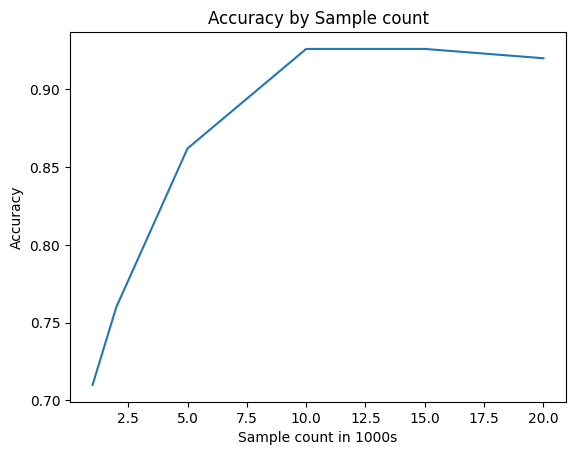

In [ ]:
# Graph for LeakyReLU accuracy

testing_parameters = [
    [ 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 2_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 5_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 10_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 15_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 20_000, 0.1, 128, 32, 10, 0.01, False, 42],
]
samples = [1, 2, 5, 10, 15, 20]
accuracies = []

for sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state in testing_parameters:
  accuracy = test_leakyrelu_graph(sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state)
  accuracies.append(accuracy)

plt.plot(samples, accuracies)
plt.title("Accuracy by Sample count")
plt.xlabel("Sample count in 1000s")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def test_relu_graph(sample_count: int,
         test_size: float,
         layer_size1: int,
         layer_size2: int,
         epochs: int,
         learning_rate: float,
         verbose: bool,
         random_state: int):
    MNIST = fetch_openml('mnist_784', version=1)
    x, y = np.array(MNIST.data)/255, np.array(MNIST.target)

    n = sample_count
    x = x[:n]
    y = y[:n]

    x = x.astype(float)
    y = y.astype(int)

    y_temp = []
    for id in range(y.size):
        y_temp.append([0 for _ in range(10)])
        y_temp[-1][y[id]] = 1

    y = np.array(y_temp)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

    layers = [
        FullyConnected(input_size=784, output_size=layer_size1),
        ReLU(),
        FullyConnected(input_size=layer_size1, output_size=layer_size2),
        ReLU(),
        FullyConnected(input_size=layer_size2, output_size=10),
        ReLU()
    ]

    net = Network(layers, learning_rate=0.1)
    mse = Loss(mse_loss, mse_loss_derivative)
    net.compile(loss=mse)

    for x_tr, y_tr in zip(x_train, y_train):
        net.fit(x_tr, y_tr, epochs=epochs, learning_rate=None, verbose=verbose)

    predictions = net(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test, axis=1)

    accuracy = np.mean(predicted_classes == actual_classes)
    return accuracy

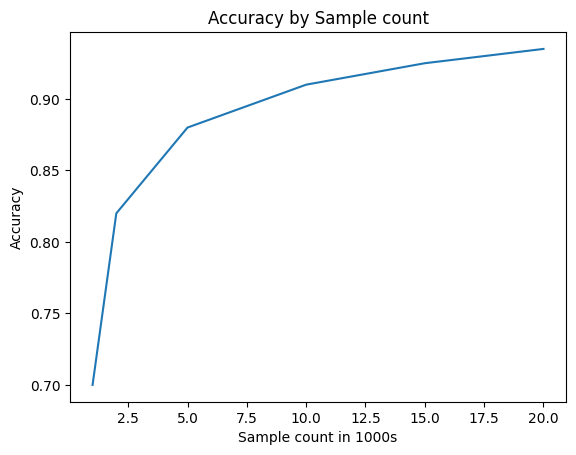

In [ ]:
# Graph for ReLU accuracy

testing_parameters = [
    [ 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 2_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 5_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 10_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 15_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 20_000, 0.1, 128, 32, 10, 0.01, False, 42],
]
samples = [1, 2, 5, 10, 15, 20]
accuracies = []

for sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state in testing_parameters:
  accuracy = test_relu_graph(sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state)
  accuracies.append(accuracy)

plt.plot(samples, accuracies)
plt.title("Accuracy by Sample count")
plt.xlabel("Sample count in 1000s")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def test_tanh_graph(sample_count: int,
         test_size: float,
         layer_size1: int,
         layer_size2: int,
         epochs: int,
         learning_rate: float,
         verbose: bool,
         random_state: int):
    MNIST = fetch_openml('mnist_784', version=1)
    x, y = np.array(MNIST.data)/255, np.array(MNIST.target)

    n = sample_count
    x = x[:n]
    y = y[:n]

    x = x.astype(float)
    y = y.astype(int)

    y_temp = []
    for id in range(y.size):
        y_temp.append([0 for _ in range(10)])
        y_temp[-1][y[id]] = 1

    y = np.array(y_temp)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)

    layers = [
        FullyConnected(input_size=784, output_size=layer_size1),
        Tanh(),
        FullyConnected(input_size=layer_size1, output_size=layer_size2),
        Tanh(),
        FullyConnected(input_size=layer_size2, output_size=10),
        Tanh()
    ]

    net = Network(layers, learning_rate=0.1)
    mse = Loss(mse_loss, mse_loss_derivative)
    net.compile(loss=mse)

    for x_tr, y_tr in zip(x_train, y_train):
        net.fit(x_tr, y_tr, epochs=epochs, learning_rate=None, verbose=verbose)

    predictions = net(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    actual_classes = np.argmax(y_test, axis=1)

    accuracy = np.mean(predicted_classes == actual_classes)
    return accuracy

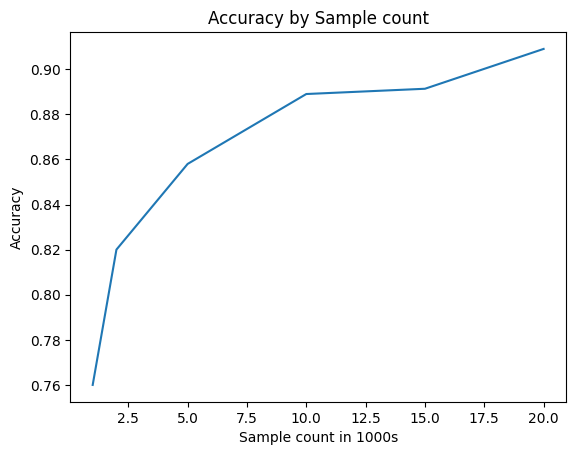

In [ ]:
# Graph for Tanh accuracy

testing_parameters = [
    [ 1_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 2_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 5_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 10_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 15_000, 0.1, 128, 32, 10, 0.01, False, 42],
    [ 20_000, 0.1, 128, 32, 10, 0.01, False, 42],
]
samples = [1, 2, 5, 10, 15, 20]
accuracies = []

for sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state in testing_parameters:
  accuracy = test_tanh_graph(sample_count, test_size, layer_size1, layer_size2, epochs, learning_rate, verbose, random_state)
  accuracies.append(accuracy)

plt.plot(samples, accuracies)
plt.title("Accuracy by Sample count")
plt.xlabel("Sample count in 1000s")
plt.ylabel("Accuracy")
plt.show()

# Wnioski

Wpływ funkcji aktywacji na dokładność (accuracy):


*   Funkcja **Tanh** może osiągać dobre wyniki, szczególnie w modelach, gdzie
dane są skalowane w zakresie [-1, 1]. Jednak jej skuteczność może być ograniczona przez problem zanikającego gradientu przy głębszych sieciach.
*   **ReLU** wykazuje wysoką skuteczność, szczególnie w przypadku większych zestawów danych i głębszych sieci neuronowych. Dzięki eliminacji problemu zanikającego gradientu jest to powszechnie stosowana funkcja aktywacji.
*   **LeakyReLU**, będąca modyfikacją ReLU, radzi sobie lepiej w sytuacjach, gdzie gradienty mogą wynosić 0. Może poprawiać dokładność w porównaniu do zwykłej ReLU, szczególnie w przypadku skomplikowanych problemów.

Wpływ rozmiaru próbek:



*   Przy mniejszych próbkach dokładność modeli może być niestabilna. Mniejsza ilość danych może prowadzić do niedouczenia modelu i gorszych wyników dokładności.
*   Większe próbki danych zazwyczaj prowadzą do wyższej dokładności, ponieważ model ma dostęp do większej liczby przykładów, co ułatwia trening i uogólnienie.

